In [2]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install biopandas -q

In [4]:
import numpy as np
import torch
import pandas as pd
from biopandas.pdb import PandasPdb
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [5]:
from Bio.PDB import DSSP, HSExposureCB, PPBuilder, is_aa, NeighborSearch
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.SeqUtils import seq1
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from timeit import default_timer as timer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score


2024-09-09 14:02:47.428389: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 14:02:47.559925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 14:02:47.608046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 14:02:47.624177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 14:02:47.727049: I tensorflow/core/platform/cpu_feature_guar

In [6]:
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from torch_geometric.data import Dataset, Dataset, download_url, Data,  Batch

In [8]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import os

current_directory = os.getcwd()
path_ring = current_directory + "/data/features_ring/"
path_pdb = current_directory + "/data/pdb_files/"
path_pdb

'/home/noob/protein-structure-classification/data/pdb_files/'

In [11]:
# Combine all PDBs into a single dataframe
dfs = []
for filename in os.listdir(path_ring):
    dfs.append(pd.read_csv(path_ring + filename, sep='\t'))
df = pd.concat(dfs)
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,3m7l,A,123,,R,H,0.032,19.0,10.0,-1.747,...,8.0,-1.006,-0.533,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
1,3m7l,A,104,,I,H,0.485,9.0,11.0,-1.124,...,13.0,-1.087,-0.709,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND
2,3m7l,A,104,,I,H,0.485,9.0,11.0,-1.124,...,13.0,-1.087,-0.709,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
3,3m7l,A,163,,H,H,0.293,6.0,18.0,-1.153,...,13.0,-0.982,-0.733,H,-0.384,1.652,1.330,1.045,2.064,NaN
4,3m7l,A,139,,H,-,0.049,20.0,18.0,-2.085,...,21.0,-1.033,-0.452,H,-1.006,-0.590,1.891,-0.397,0.412,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,4a6r,B,400,,I,H,0.101,20.0,13.0,-1.236,...,11.0,-0.981,-0.860,H,-1.006,-0.590,1.891,-0.397,0.412,VDW
1569,4a6r,A,382,,F,E,0.000,16.0,23.0,-2.681,...,22.0,-1.832,2.234,H,-1.239,-0.547,2.131,0.393,0.816,HBOND
1570,4a6r,A,266,,G,T,0.000,26.0,24.0,1.706,...,21.0,1.784,-0.508,L,-0.384,1.652,1.330,1.045,2.064,HBOND
1571,4a6r,B,303,,G,-,0.083,14.0,19.0,-1.338,...,20.0,-1.089,-0.757,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND


In [12]:
df.dropna(inplace=True)
y = df['Interaction'].astype('category')
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,3m7l,A,123,,R,H,0.032,19.0,10.0,-1.747,...,8.0,-1.006,-0.533,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
1,3m7l,A,104,,I,H,0.485,9.0,11.0,-1.124,...,13.0,-1.087,-0.709,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND
2,3m7l,A,104,,I,H,0.485,9.0,11.0,-1.124,...,13.0,-1.087,-0.709,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
4,3m7l,A,139,,H,-,0.049,20.0,18.0,-2.085,...,21.0,-1.033,-0.452,H,-1.006,-0.590,1.891,-0.397,0.412,HBOND
5,3m7l,A,139,,H,-,0.049,20.0,18.0,-2.085,...,21.0,-1.033,-0.452,H,-1.006,-0.590,1.891,-0.397,0.412,VDW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,4a6r,B,400,,I,H,0.101,20.0,13.0,-1.236,...,11.0,-0.981,-0.860,H,-1.006,-0.590,1.891,-0.397,0.412,VDW
1569,4a6r,A,382,,F,E,0.000,16.0,23.0,-2.681,...,22.0,-1.832,2.234,H,-1.239,-0.547,2.131,0.393,0.816,HBOND
1570,4a6r,A,266,,G,T,0.000,26.0,24.0,1.706,...,21.0,1.784,-0.508,L,-0.384,1.652,1.330,1.045,2.064,HBOND
1571,4a6r,B,303,,G,-,0.083,14.0,19.0,-1.338,...,20.0,-1.089,-0.757,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND


# Label Encoder Function

In [13]:
#Let's transform the data, s.t. all features are numerical
label_encoder = LabelEncoder()

def encode_object_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype(str)
            df[column] = label_encoder.fit_transform(df[column])
    return df

# Compute the distances between source residue and target residue using BioPython

In [14]:
from Bio import PDB
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed

def get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file_path)
    model = structure[0]

    # Locate the source and target chains
    try:
        s_chain = model[s_ch]
        t_chain = model[t_ch]
    except KeyError:
        raise ValueError(f"Chain {s_ch} or {t_ch} not found in structure {pdb_id}")

    # Locate the source and target residues by residue index
    try:
        s_residue = s_chain[s_resi]
        t_residue = t_chain[t_resi]
    except KeyError:
        raise ValueError(f"Residue {s_resi} or {t_resi} not found in chains {s_ch} or {t_ch}")
    try:
        s_ca = s_residue['CA']
        t_ca = t_residue['CA']
    except KeyError:
        raise ValueError(f"Alpha-carbon not found in residue {s_resi} or {t_resi}")
    
    s_ca_coord = s_ca.get_coord()
    t_ca_coord = t_ca.get_coord()

    distance = np.linalg.norm(s_ca_coord - t_ca_coord)

    return distance


def process_row(index, row, pdb_directory):
    pdb_id = row['pdb_id']
    s_resi = row['s_resi']
    t_resi = row['t_resi']
    s_ch = row['s_ch']
    t_ch = row['t_ch']

    pdb_file_path = os.path.join(pdb_directory, f'{pdb_id}.pdb')

    if not os.path.isfile(pdb_file_path):
        print(f"File {pdb_file_path} does not exist.")
        return None

    try:
        # Compute the CA-CA distance
        distance = get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path)
        return distance
    except Exception as e:
        print(f"Error processing {pdb_id} (row {index}): {e}")
        return None


def calculate_distances_parallel(df, pdb_directory, n_jobs=-1):
    # Use Parallel to process each row in the dataframe in parallel
    ca_distances = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(index, row, pdb_directory) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows")
    )
    
    # Add the result to the dataframe
    df['CA_CA_distance'] = ca_distances
    return df


# Example usage
# Assuming path_pdb is defined and df is the dataframe you're processing
pdb_directory = path_pdb
df = calculate_distances_parallel(df, pdb_directory, n_jobs=-1)



Processing Rows:   0%|          | 3860/1471380 [00:18<2:35:32, 157.25it/s]

# Electrostatic Interaction

In [29]:
one_to_three_letter = {
    'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'D': 'ASP', 'C': 'CYS',
    'E': 'GLU', 'Q': 'GLN', 'G': 'GLY', 'H': 'HIS', 'I': 'ILE',
    'L': 'LEU', 'K': 'LYS', 'M': 'MET', 'F': 'PHE', 'P': 'PRO',
    'S': 'SER', 'T': 'THR', 'W': 'TRP', 'Y': 'TYR', 'V': 'VAL'
}

def get_residue_charge(resn):
    charges = {'ASP': -1, 'GLU': -1, 'LYS': 1, 'ARG': 1, 'HIS': 1}
    return charges.get(resn, 0)  # Default to 0 for neutral residues

def compute_electrostatic_energy(q1, q2, r, epsilon=4.0):
    """Calculates electrostatic energy using Coulomb's Law"""
    k_e = 8.9875 * 10**9  # Coulomb constant in N·m²/C²
    return (k_e * q1 * q2) / (epsilon * r)

def compute_interaction(s_resn, t_resn, distance):
    """Computes electrostatic interaction energy using separate parameters"""
    # Convert one-letter codes to three-letter codes
    s_resn_three = one_to_three_letter.get(s_resn, None)
    t_resn_three = one_to_three_letter.get(t_resn, None)

    if s_resn_three is None or t_resn_three is None:
        print(f"Invalid residue code: {s_resn} or {t_resn}")
        return None

    # Get residue charges
    q1 = get_residue_charge(s_resn_three)
    q2 = get_residue_charge(t_resn_three)

    if distance is None or distance == 0:
        print(f"Distance error for residue pair: {s_resn} - {t_resn}")
        return None

    # Compute electrostatic interaction energy
    return compute_electrostatic_energy(q1, q2, distance)

computed_energies = []

# Loop through each row in the df
for index, row in df_mini.iterrows():
    distance = row['CA_CA_distance']
    energy = compute_interaction(row['s_resn'], row['t_resn'], distance)
    computed_energies.append(energy)
df_mini['electrostatic_energy'] = computed_energies

Distance error for residue pair: R - L
Distance error for residue pair: I - L
Distance error for residue pair: I - L
Distance error for residue pair: H - F
Distance error for residue pair: H - F
Distance error for residue pair: A - H
Distance error for residue pair: L - F
Distance error for residue pair: K - K
Distance error for residue pair: F - V
Distance error for residue pair: F - S
Distance error for residue pair: F - S
Distance error for residue pair: V - V
Distance error for residue pair: Y - R
Distance error for residue pair: Y - L
Distance error for residue pair: A - A
Distance error for residue pair: A - A
Distance error for residue pair: N - A
Distance error for residue pair: N - A
Distance error for residue pair: L - K
Distance error for residue pair: W - S
Distance error for residue pair: F - A
Distance error for residue pair: F - A
Distance error for residue pair: S - F
Distance error for residue pair: H - I
Distance error for residue pair: L - R
Distance error for residu

In [32]:
df_mini


,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction,CA_CA_distance,electrostatic_energy
0,3hmz,A,37,,S,E,0.077,13.0,10.0,-2.562,...,-0.759,H,0.931,-0.179,-3.005,-0.503,-1.853,HBOND,6.653373,0.0
1,3hmz,A,108,,L,H,0.780,2.0,17.0,-1.194,...,0.491,L,-0.384,1.652,1.330,1.045,2.064,HBOND,5.174891,0.0
4,3hmz,A,61,,V,E,0.000,24.0,15.0,-2.582,...,2.380,H,-1.006,-0.590,1.891,-0.397,0.412,HBOND,5.260814,0.0
5,3hmz,A,70,,R,H,0.056,13.0,22.0,-1.005,...,-0.732,H,-1.239,-0.547,2.131,0.393,0.816,VDW,5.047226,0.0
8,3hmz,A,87,,A,G,0.651,10.0,13.0,-1.013,...,0.006,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND,5.131230,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,3k67,A,19,,Y,H,0.000,22.0,12.0,-0.923,...,0.075,H,1.831,-0.561,0.533,-0.277,1.648,HBOND,5.174559,0.0
500,3k67,A,19,,Y,H,0.000,22.0,12.0,-0.923,...,0.075,H,1.831,-0.561,0.533,-0.277,1.648,VDW,5.174559,0.0
501,3k67,A,108,,Q,E,0.010,20.0,19.0,-2.471,...,2.487,H,-1.006,-0.590,1.891,-0.397,0.412,HBOND,5.507362,0.0
502,3k67,A,110,,F,E,0.015,19.0,16.0,-2.285,...,2.580,H,1.357,-1.453,1.477,0.113,-0.837,VDW,5.580744,-0.0


In [30]:

df_mini['electrostatic_energy'].unique()

array([ 0.00000000e+00, -4.10761945e+08, -2.44458581e+08,  2.43539455e+08,
       -2.97324211e+08,  3.95292567e+08, -4.08788996e+08, -4.35496361e+08,
       -4.66124943e+08,  3.09702583e+08, -3.65841519e+08,  4.36993741e+08,
       -5.09903419e+08, -4.30350967e+08, -2.36734291e+08,  3.66261953e+08,
        2.29634612e+08, -3.81266904e+08, -1.91383507e+08, -1.96434968e+08,
       -1.91616801e+08,  3.26312980e+08, -3.08006281e+08, -2.54434280e+08,
        4.57824514e+08,  2.30533277e+08, -3.01377576e+08,  2.28753342e+08,
        3.59452419e+08, -4.33609147e+08, -2.41708690e+08,  3.60306175e+08,
       -2.43057214e+08, -3.94158241e+08, -2.42004711e+08, -3.76208068e+08,
       -2.40498272e+08,  3.73954622e+08, -1.93220223e+08,  2.29837638e+08,
       -3.87880799e+08,  3.57655538e+08, -3.85078682e+08, -2.56466272e+08,
        4.34151405e+08,  2.93582423e+08, -2.91351074e+08,  3.43561225e+08,
       -3.56559996e+08,  4.23103185e+08,  2.77649394e+08, -2.12196020e+08,
       -2.71411616e+08, -

# Residue-specific All-atom conditional Probability Discriminatory Function

In [40]:
 # Here we should create and train our own RAPDF model O.o

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.97      0.72       453
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         5
           4       0.03      0.09      0.05        11
           5       0.00      0.00      0.00       315

    accuracy                           0.55       800
   macro avg       0.12      0.21      0.15       800
weighted avg       0.32      0.55      0.41       800

Accuracy Score: 0.55


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [33]:
# Here we should use our RAPDF model
# from sklearn.linear_model import LogisticRegression

# features = df_mini.columns.tolist()

# # Load pre-trained RACPDF model
# racpdf_model = LogisticRegression()

# def compute_racpdf(model, features):
#     return model.predict_proba(features)[:, 1]
# df_mini['racpdf'] = compute_racpdf(racpdf_model, features)
# df_mini

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Let's transform the data, s.t. all features are numerical
label_encoder = LabelEncoder()

def encode_object_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype(str)
            df[column] = label_encoder.fit_transform(df[column])
    return df

df = encode_object_columns(df)

print(df)

     pdb_id  s_ch  s_resi  s_ins  s_resn  s_ss8  s_rsa  s_up  s_down  s_phi  \
0       922     0      37      0      15      2  0.077  13.0    10.0 -2.562   
1       922     0     108      0       9      4  0.780   2.0    17.0 -1.194   
4       922     0      61      0      17      2  0.000  24.0    15.0 -2.582   
5       922     0      70      0      14      4  0.056  13.0    22.0 -1.005   
8       922     0      87      0       0      3  0.651  10.0    13.0 -1.013   
..      ...   ...     ...    ...     ...    ...    ...   ...     ...    ...   
499     966     0      19      0      19      4  0.000  22.0    12.0 -0.923   
500     966     0      19      0      19      4  0.000  22.0    12.0 -0.923   
501     966     0     108      0      13      2  0.010  20.0    19.0 -2.471   
502     966     0     110      0       4      2  0.015  19.0    16.0 -2.285   
503     966     0       8      0      10      4  0.000  18.0    12.0 -1.114   

     ...  t_down  t_phi  t_psi  t_ss3   t_a1   t_a2

In [ ]:
# Define training features
#X = df
#X = df[['pdb_id', 's_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
        #'t_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

# Calculate percentiles and transform into categories
#X = X.rank(pct=True).round(1).astype('category')
#X

# Features of neighbouring resodues (in a sequence not in 3D space)

In [ ]:
#Let's try to add the same features of neighbouring residues
# !!!! Mistake: one sequence is one chain,

df['s_ss8_prev'] = df['s_ss8'].shift(1)
df['s_ss8_next'] = df['s_ss8'].shift(-1)
df['s_rsa_prev'] = df['s_rsa'].shift(1)
df['s_rsa_next'] = df['s_rsa'].shift(-1)
df['t_ss8_prev'] = df['t_ss8'].shift(1)
df['t_ss8_next'] = df['t_ss8'].shift(-1)
df['t_rsa_prev'] = df['t_rsa'].shift(1)
df['t_rsa_next'] = df['t_rsa'].shift(-1)
df['s_ss8_prev'] = df['s_ss8'].shift(1)
df['s_ss8_next'] = df['s_ss8'].shift(-1)
df['s_rsa_prev'] = df['s_rsa'].shift(1)
df['s_rsa_next'] = df['s_rsa'].shift(-1)
df['s_phi_prev'] = df['s_phi'].shift(1)
df['s_phi_next'] = df['s_phi'].shift(-1)
df['s_psi_prev'] = df['s_psi'].shift(1)
df['s_psi_next'] = df['s_psi'].shift(-1)
df['t_ss8_prev'] = df['t_ss8'].shift(1)
df['t_ss8_next'] = df['t_ss8'].shift(-1)
df['t_rsa_prev'] = df['t_rsa'].shift(1)
df['t_rsa_next'] = df['t_rsa'].shift(-1)
df['t_phi_prev'] = df['t_phi'].shift(1)
df['t_phi_next'] = df['t_phi'].shift(-1)
df['t_psi_prev'] = df['t_psi'].shift(1)
df['t_psi_next'] = df['t_psi'].shift(-1)
df['s_a1_prev'] = df['s_a1'].shift(1)
df['s_a1_next'] = df['s_a1'].shift(-1)
df['t_a1_prev'] = df['t_a1'].shift(1)
df['t_a1_next'] = df['t_a1'].shift(-1)

In [ ]:
df.dropna(inplace=True)


In [ ]:
X = df.drop(columns=['Interaction'])
y = df['Interaction']
# One-hot encode the labels if they are not already
y = to_categorical(y, num_classes=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

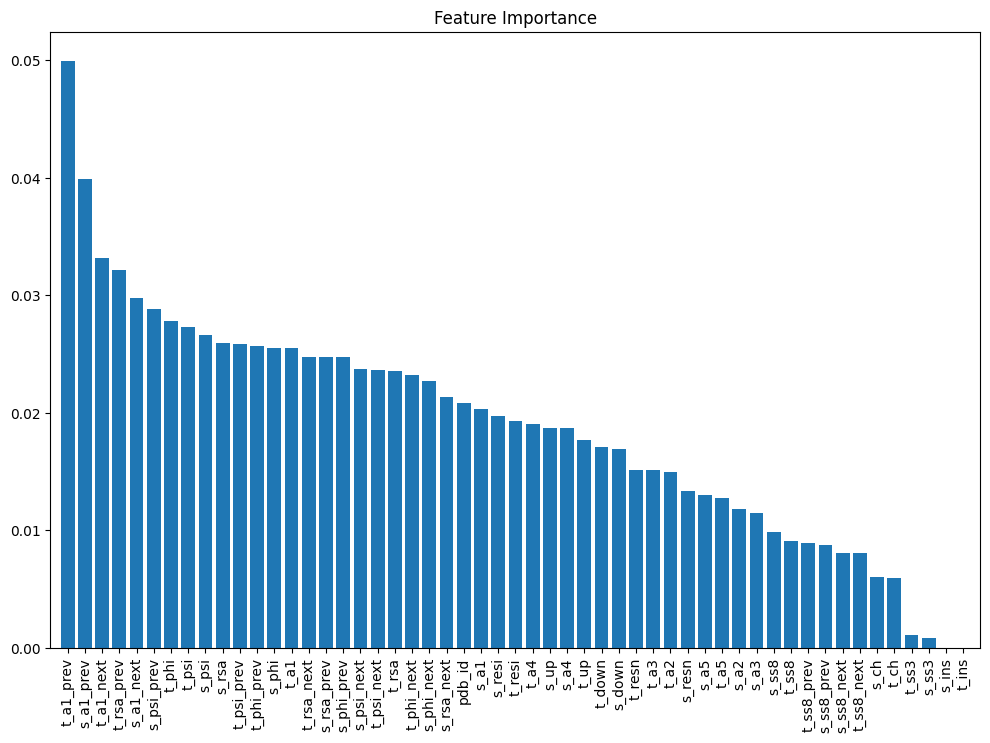

In [ ]:
# Let's check how important are our features
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample a subset of the data
sample_size = 50000  # can be adjusted
df_sample = df.sample(n=sample_size, random_state=42)

X_sample = df_sample.drop(columns=['Interaction'])
y_sample = df_sample['Interaction']

# Convert labels to one-hot encoding if necessary and then back to labels for Random Forest
y_sample = pd.get_dummies(y_sample)  # One-hot encode if needed
y_sample_labels = y_sample.values.argmax(axis=1)  # Convert back to labels

rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)  # Reduced parameters
rf.fit(X_sample, y_sample_labels)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X_sample.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sample.shape[1]), X_sample.columns[indices], rotation=90)
plt.xlim([-1, X_sample.shape[1]])
plt.show()


In [ ]:
X = df.drop(columns=['Interaction', 't_ss3', "s_ss3", "t_ins", "s_ins" ])
y = df['Interaction']  # Labels
# One-hot encode the labels if they are not already
y = to_categorical(y, num_classes=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Handling imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = Sequential()

# Input layer and first hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Third hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Fourth hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define K-Fold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store scores for each fold
fold_accuracies = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create a new model instance for each fold
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=50,
                        batch_size=32,
                        class_weight=class_weight_dict,
                        callbacks=[early_stopping],
                        verbose=0)  # Set verbose to 1 for detailed output

   # Predict the labels for the validation fold
    y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    # Compute balanced accuracy for the current fold
    balanced_acc = balanced_accuracy_score(y_val_true, y_val_pred)
    print(f"Balanced accuracy for current fold: {balanced_acc:.4f}")

    fold_accuracies.append(balanced_acc)

# Calculate and print the average balanced accuracy across all folds
average_balanced_accuracy = np.mean(fold_accuracies)
print(f"Average balanced accuracy across all folds: {average_balanced_accuracy:.4f}")


3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7609
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Balanced accuracy for current fold: 0.7656
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7707
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7830
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Balanced accuracy for current fold: 0.7634


In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.argmax(y_test, axis=1)

mcc = matthews_corrcoef(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
avg_precision = average_precision_score(y_test, y_pred_proba, average='macro')

print(f"Test accuracy: {test_acc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")


9197/9197 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
Test accuracy: 0.8098
Matthews Correlation Coefficient: 0.6454
Balanced Accuracy: 0.6038
Average Precision Score: 0.4825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
